In [1]:
import pandas as pd

In [3]:
positive_seqs = pd.read_csv('./../dataset/lin28/uniq.SRR458758.txt', header=None, names=['Sequence'])

In [4]:
positive_seqs_ln = positive_seqs[positive_seqs['Sequence'].str.len() > 70]

positive_seqs_ln.head()

,Sequence
56,12 AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
57,31 AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
58,35 AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
59,45 AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
60,117 AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...


In [4]:
positive_seqs_ln.shape

(2257841, 1)

In [5]:
# random sampling
seq_pos = positive_seqs_ln.sample(n=10000, replace=False, random_state=42)
seq_pos['Sequence'] = [''.join(filter(str.isalpha, seq)) for seq in seq_pos['Sequence']]

In [6]:
seq_len = [len(x) for x in seq_pos['Sequence']]
max(seq_len)

78

In [7]:
# make every sequence same length
MAX_LEN = 78

def padding_seq(seq):
    gap = MAX_LEN - len(seq)
    res = 'N'*int(gap/2) + seq + 'N'*int(gap/2)
    
    if gap % 2 == 1:
        res += 'N'
    
    return res

In [8]:
seqs = [padding_seq(seq) for seq in seq_pos['Sequence']]

In [9]:
seqs[:5]

['GTTGTAAAACCTGTTCACCAGCACCTGCGGAATTGTTGCCCTGCCTTCATTTCTTTCCCAGCCTGTAGGCACCATCAA',
 'ATTCTCTTCTGTGTGTCACCAAGTTCAGGCCTGGTGGCCAGGCCTGCTCTGTAGGCACCATCAATCGTATGCCGTCTT',
 'NAGAACGGCTGGTCTTTCATCAGAATTCCAGGCAAGAAGAGCCTCATCACTGACAGTGGAAAGCCTGTAGGCACCANN',
 'TGGGATGTGTGTGTGTGTTACTGGGATGGGGTGAGTGTGTGTGTGTGTGTGCTCTCTCGCGCATATGCACACAAGCCT',
 'AGCTTAACTCATTTGAATGTTGTTGCTTCTGAGTTTAGGCTAACGGAAGTCTGTAGGCACCATCAATTCGTATGCCGT']

In [10]:
seq_pos['Sequence'] = seqs
seq_pos['y'] = '1'

In [11]:
print(max([len(x) for x in seq_pos['Sequence']]), min([len(x) for x in seq_pos['Sequence']]))

78 78


In [12]:
# random sequence for negative sample
import random

seq_len = 78

ranseq = []
for i in range(10000):
    ranseq.append(''.join(random.choices(['A', 'C', 'T', 'G', 'N'], k=seq_len)))

In [13]:
ranseq[:5]

['TTGTTAGATGCTCAGGNGTTGGGCNTCCTCCNTGTAGATTGCCTAGNGAATNTANNTCCGNTCTCNATGAAAATTNGT',
 'CCTCGCCNTNNGANGTTGCNGNGACCNANACAGNNATGCAGNCAANCATACTTANGGNGTNTCANAAANGGTCCANCG',
 'CGNGCTCNTGNCNGTGCGCNGTNAGATAATCCNGAGCGGANGGGCCNATCGCCNGTTNGTAGNCTTTAGAAAATTATN',
 'TGTGAGTAGNAGATATTNNGGGGGGAGNNANNNTNGAAAATTGAAGTAGCGNCCNTGACCCCCANAGNTAGTGNGTCA',
 'GAGGGTTTTTATGCCANGACCGTNCCGGCCGGTNGTATCGCACANCGCGCCNTTGAATGNGTTGCGCGNTGANTANTC']

In [14]:
seq_neg = pd.DataFrame(ranseq, columns=['Sequence'])
seq_neg['y'] = '0'

seq_neg.head()

,Sequence,y
0,TTGTTAGATGCTCAGGNGTTGGGCNTCCTCCNTGTAGATTGCCTAG...,0
1,CCTCGCCNTNNGANGTTGCNGNGACCNANACAGNNATGCAGNCAAN...,0
2,CGNGCTCNTGNCNGTGCGCNGTNAGATAATCCNGAGCGGANGGGCC...,0
3,TGTGAGTAGNAGATATTNNGGGGGGAGNNANNNTNGAAAATTGAAG...,0
4,GAGGGTTTTTATGCCANGACCGTNCCGGCCGGTNGTATCGCACANC...,0


In [15]:
seq_pos.head()

,Sequence,y
7601271,GTTGTAAAACCTGTTCACCAGCACCTGCGGAATTGTTGCCCTGCCT...,1
5073481,ATTCTCTTCTGTGTGTCACCAAGTTCAGGCCTGGTGGCCAGGCCTG...,1
2669291,NAGAACGGCTGGTCTTTCATCAGAATTCCAGGCAAGAAGAGCCTCA...,1
8012620,TGGGATGTGTGTGTGTGTTACTGGGATGGGGTGAGTGTGTGTGTGT...,1
3455182,AGCTTAACTCATTTGAATGTTGTTGCTTCTGAGTTTAGGCTAACGG...,1


In [16]:
seqs = pd.concat([seq_pos, seq_neg])
seqs = seqs.sample(frac=1).reset_index(drop=True)
seqs.head()

,Sequence,y
0,GGCTGCNTCGGNNAGTATANNCNTTTAGGGGGCGTCAAANTTATAA...,0
1,AGCAGAGGCCTCGGAAGCTGACTCTGATGGGCAGCAATGGGCATGA...,1
2,GCTGCTNTCTCCTCANNNCAAATCNCCNCNAGACGCTGTNNNCTNN...,0
3,GAACAGNTATCCNTACGAGTNCGCCCCACNGGAACAAANTTGANAA...,0
4,AGNACGGACCCGATNGNCGCGNAGTCANGATNGANNNCNCNAAANN...,0


In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, regularizers, constraints
from tensorflow.keras.layers import Layer, Input, Embedding, Conv1D, Conv2D, BatchNormalization, ReLU, LeakyReLU, MaxPooling1D, Flatten, Dense, Softmax, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [18]:
train_X = seqs['Sequence'][:15000]
train_y = seqs['y'][:15000]

test_X = seqs['Sequence'][15000:]
test_y = seqs['y'][15000:]

In [19]:
BASE=sorted("ACGTN")

train_X_int = [[BASE.index(c) for c in seq] for seq in train_X.tolist()]
train_X_onehot = np.eye(len(BASE))[train_X_int]

test_X_int = [[BASE.index(c) for c in seq] for seq in test_X.tolist()]
test_X_onehot = np.eye(len(BASE))[test_X_int]

train_X_onehot_ = train_X_onehot[:, :, :, np.newaxis]
test_X_onehot_ = test_X_onehot[:, :, :, np.newaxis]

In [20]:
train_X_onehot_.shape

(15000, 78, 5, 1)

In [21]:
test_X_onehot_.shape

(5000, 78, 5, 1)

In [22]:
train_X_onehot_ = np.array(train_X_onehot_)
test_X_onehot_ = np.array(test_X_onehot_)

train_y = train_y.astype('int32')
test_y = test_y.astype('int32')

In [23]:
train_y[:5]

0    0
1    1
2    0
3    0
4    0
Name: y, dtype: int32

In [24]:
mymodel = tf.keras.Sequential([
    Conv2D(1, (14, 5), padding='same', strides=1, input_shape=(78, 5, 1), kernel_regularizer=regularizers.l1(3e-3), kernel_constraint=constraints.NonNeg()),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(),
    
    Flatten(),
    Dense(1, activation='sigmoid')
])

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2022-06-10 07:25:20.449986: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-10 07:25:20.450118: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [25]:
mymodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 5, 1)          71        
                                                                 
 batch_normalization (BatchN  (None, 78, 5, 1)         4         
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 78, 5, 1)          0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 2, 1)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 78)                0         
                                                                 
 dense (Dense)               (None, 1)                 7

In [26]:
mymodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
mymodel.fit(train_X_onehot_, train_y, epochs=20, validation_split=0.2)

Epoch 1/20


2022-06-10 07:25:40.296447: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-10 07:25:40.517159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


365/375 [============================>.] - ETA: 0s - loss: 0.6726 - accuracy: 0.6050

2022-06-10 07:25:44.398877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - 5s 6ms/step - loss: 0.6635 - accuracy: 0.6127 - val_loss: 0.3817 - val_accuracy: 0.8573
Epoch 2/20
375/375 [==============================] - 2s 6ms/step - loss: 0.2738 - accuracy: 0.9034 - val_loss: 0.1971 - val_accuracy: 0.9393
Epoch 3/20
375/375 [==============================] - 2s 6ms/step - loss: 0.1738 - accuracy: 0.9467 - val_loss: 0.1281 - val_accuracy: 0.9647
Epoch 4/20
375/375 [==============================] - 2s 6ms/step - loss: 0.1281 - accuracy: 0.9602 - val_loss: 0.1002 - val_accuracy: 0.9723
Epoch 5/20
375/375 [==============================] - 2s 6ms/step - loss: 0.0948 - accuracy: 0.9743 - val_loss: 0.0739 - val_accuracy: 0.9813
Epoch 6/20
375/375 [==============================] - 2s 6ms/step - loss: 0.0699 - accuracy: 0.9818 - val_loss: 0.0658 - val_accuracy: 0.9823
Epoch 7/20
375/375 [==============================] - 2s 6ms/step - loss: 0.0615 - accuracy: 0.9839 - val_loss: 0.0566 - val_accuracy: 0.9863
Epoch 8/20
375/37

In [28]:
mymodel.evaluate(test_X_onehot_, test_y, verbose=2)

157/157 - 1s - loss: 0.0254 - accuracy: 0.9950 - 585ms/epoch - 4ms/step


[0.025430822744965553, 0.9950000643730164]

In [29]:
weights = mymodel.get_weights()
weight = pd.DataFrame(np.squeeze(weights[0].transpose()))

In [30]:
weight

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.067291,0.116742,0.177601,0.129128,0.130714,0.116229,0.090775,0.079382,0.114714,0.090486,0.145544,0.034634,0.116574,0.141821
1,0.040393,0.021171,0.028777,0.058148,0.081159,0.028351,0.044380,0.081534,0.016225,0.069410,0.000682,0.015767,0.090529,0.033255
2,0.012622,0.017880,0.004180,0.019306,0.025775,0.004676,0.023750,0.040249,0.015801,0.000106,0.142618,-0.000000,0.001033,0.018530
3,-0.000000,-0.000000,0.004139,0.006274,0.000199,0.000202,0.007436,0.017027,-0.000000,0.056852,0.048528,0.004457,-0.000000,0.002183
4,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.425731,-0.000000,-0.000000,-0.000000


In [31]:
weight += 0.001
weight = weight / weight.sum(axis=0)

weight.sum(axis=0)

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
dtype: float32

In [32]:
weight.index = sorted(list('ACGTN'))

weight = weight.transpose()
weight['-'] = 0.0

weight

,A,C,G,N,T,-
0,0.544993,0.330335,0.108711,0.007980,0.007980,0.0
1,0.732256,0.137888,0.117418,0.006219,0.006219,0.0
2,0.812938,0.135538,0.023579,0.023393,0.004552,0.0
3,0.597310,0.271500,0.093209,0.033390,0.004590,0.0
4,0.542374,0.338318,0.110253,0.004937,0.004118,0.0
5,0.758970,0.190027,0.036747,0.007782,0.006474,0.0
6,0.535630,0.264851,0.144447,0.049236,0.005836,0.0
7,0.360147,0.369789,0.184813,0.080771,0.004480,0.0
8,0.762583,0.113516,0.110721,0.006590,0.006590,0.0
9,0.412369,0.317372,0.004984,0.260767,0.004507,0.0


In [ ]:
weight.to_csv('pfm.csv')

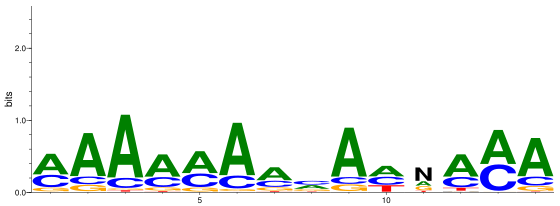

In [27]:
import pandas as pd
import seqlogo

weight = pd.read_csv('pfm.csv').iloc[:, 1:]

logoPm = seqlogo.CompletePm(pfm=weight, background=0.25, alphabet_type="reduced DNA")

seqlogo.seqlogo(logoPm, size='large')